# Projet Machine Learning 1  
## Classification de la qualité du vin (red & white)

**Cours :** Machine Learning I – EFREI  
**Encadrant :** Ahmad TAY

Objectif : développer un modèle de **classification supervisée** capable de prédire la qualité d'un vin à partir de variables physico-chimiques.  
On transforme ensuite le problème en **classification binaire** :  
- `1` = bon vin (qualité ≥ 7)  
- `0` = vin moyen ou mauvais (qualité < 7)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

# 1. Prétraitement des données

In [4]:
# Chargement des données vin
red = pd.read_csv("winequality-red.csv", sep=";")
white = pd.read_csv("winequality-white.csv", sep=";")

print("Shape red :", red.shape)
print("Shape white :", white.shape)

# Ajout d'une colonne pour la couleur
red["wine type"] = "red"
white["wine type"] = "white"

# Fusion des deux jeux de données
data = pd.concat([red, white], axis=0).reset_index(drop=True)

print("Shape combined :", data.shape)

# Aperçu des premières lignes
data.head()

Shape red : (1599, 12)
Shape white : (4898, 12)
Shape combined : (6497, 13)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality wine type  
0      9.4        5       red  
1      9.8        5       red  
2      9.8        5       red  
3      9.8        6       red  
4      9.4        5       red

## Explication des Colonnes du Dataset Vin

Le dataset utilisé pour la prédiction de la qualité des vins contient un ensemble de caractéristiques physico-chimiques mesurées en laboratoire sur des vins rouges et blancs.  
Ces variables permettent d’estimer objectivement la qualité sensorielle d’un vin.

Voici une description détaillée de chaque colonne du dataset.

---

### 1. fixed acidity  
**Description :** Quantité d’acides non volatiles dans le vin, principalement l’acide tartrique.  
**Type :** Flottant (float)  
**Exemple :** 7.4 g/dm³  
**Interprétation :** Plus l’acidité fixe est élevée, plus le vin peut paraître « vif » ou acide.

---

### 2. volatile acidity  
**Description :** Teneur en acides volatils (acide acétique notamment), responsables d’une odeur de vinaigre lorsqu’ils sont trop élevés.  
**Type :** Flottant (float)  
**Exemple :** 0.70 g/dm³  
**Interprétation :** Un taux trop élevé dégrade fortement la qualité du vin.

---

### 3. citric acid  
**Description :** Quantité d’acide citrique, utilisé pour apporter fraîcheur et équilibre.  
**Type :** Flottant (float)  
**Exemple :** 0.00 g/dm³  
**Interprétation :** L’acide citrique influence l’acidité perçue et la stabilité du vin.

---

### 4. residual sugar  
**Description :** Sucre résiduel dans le vin après fermentation.  
**Type :** Flottant (float)  
**Exemple :** 1.9 g/dm³  
**Interprétation :** Plus la valeur est élevée, plus le vin sera doux ou sucré.

---

### 5. chlorides  
**Description :** Concentration de chlorures (principalement le sel) dans le vin.  
**Type :** Flottant (float)  
**Exemple :** 0.076 g/dm³  
**Interprétation :** Des chlorures trop élevés peuvent altérer la qualité.

---

### 6. free sulfur dioxide  
**Description :** Dioxyde de soufre libre, utilisé comme conservateur.  
**Type :** Flottant (float)  
**Exemple :** 11.0 mg/dm³  
**Interprétation :** Protège le vin contre l’oxydation et les microbes.

---

### 7. total sulfur dioxide  
**Description :** Quantité totale de dioxyde de soufre (libre + combiné).  
**Type :** Flottant (float)  
**Exemple :** 34.0 mg/dm³  
**Interprétation :** Un excès peut provoquer des arômes indésirables.

---

### 8. density  
**Description :** Densité du vin (liée à l’alcool et au sucre).  
**Type :** Flottant (float)  
**Exemple :** 0.9978 g/cm³  
**Interprétation :** Les vins sucrés ont une densité plus élevée.

---

### 9. pH  
**Description :** Niveau d’acidité global du vin.  
**Type :** Flottant (float)  
**Exemple :** 3.51  
**Interprétation :**  
- Un pH bas = vin plus acide  
- Un pH élevé = vin moins acide

---

### 10. sulphates  
**Description :** Sulfates, ajoutés parfois pour améliorer la stabilité et la protection microbienne.  
**Type :** Flottant (float)  
**Exemple :** 0.56 g/dm³  
**Interprétation :** Peuvent influencer la qualité et la conservation.

---

### 11. alcohol  
**Description :** Teneur en alcool du vin.  
**Type :** Flottant (float)  
**Exemple :** 9.4 % vol  
**Interprétation :** L’alcool apporte chaleur, structure et influence la qualité.

---

### 12. quality  
**Description :** Note de qualité attribuée par des experts, sur une échelle de **0 à 10**.  
**Type :** Entier (int)  
**Exemple :** 5  
**Utilisation :** Cette variable sera transformée en variable **binaire** (0 = qualité < 7, 1 = qualité ≥ 7).

---

### 13. wine type  
**Description :** Indique si le vin est **rouge** ou **blanc**.  
**Type :** Catégoriel (str)  
**Exemple :** "red" ou "white"

---

Ces caractéristiques seront utilisées pour entraîner les modèles de classification dans le cadre du projet.


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [16]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine type               0
dtype: int64

In [18]:
data.isna().any().any()

False

## Informations générales sur le dataset

La commande `data.info()` permet d’obtenir un aperçu global de la structure du dataset.
On remarque les points suivants :

Le dataset contient **6 497** lignes et **13** colonnes.

et grace a la commande `data.isna().sum()`et `data.isna().any().any()`, on voit clairement que toutes les colonnes numériques (acidity, sugar, sulfur dioxide, alcohol, etc.) sont complètes : aucune valeur manquante n’est détectée.

La variable wine type est la seule colonne de type catégoriel (object), indiquant si l’échantillon correspond à un vin rouge ou blanc.

L’ensemble des autres colonnes sont de type float64 ou int64, indiquant que les données sont prêtes pour les opérations statistiques et graphiques.


In [11]:
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

La valeur minimale observée dans dans la colonne *citric acid = 0*, est cohérente avec la description du fichier **winequality.names**, où il est précisé que l’acide citrique *« can be very low in some wines »*.  
Ainsi, toutes les valeurs présentes sont valides et correspondent à des mesures physico-chimiques réelles du vin.

### Distribution des valeurs de la variable *quality*

Avant de transformer la qualité en variable binaire, il est important d'observer la distribution des notes (de 0 à 10).  
Cela permet de vérifier si certaines classes sont majoritaires ou minoritaires et de mieux comprendre l’équilibre du dataset.

In [24]:
data["quality"].value_counts().sort_index()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_23660\565092773.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




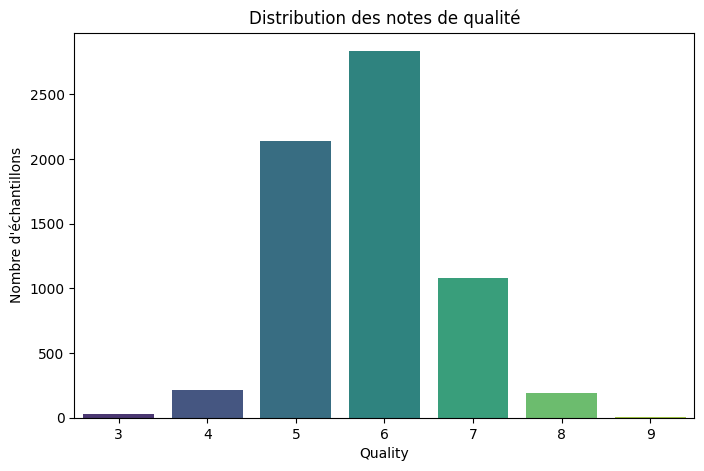

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x=data["quality"], palette="viridis")
plt.title("Distribution des notes de qualité")
plt.xlabel("Quality")
plt.ylabel("Nombre d'échantillons")
plt.show()

Le graphique ci-dessus montre que la grande majorité des vins appartiennent aux classes de qualité **5** et **6**, tandis que les vins de bonne qualité (7, 8, 9) sont beaucoup moins nombreux.  
Ce phénomène correspond à un **déséquilibre de classes (imbalanced data)**, où la classe majoritaire domine largement le dataset.  

Lors de l’entraînement des modèles de machine learning, ce type de déséquilibre peut représenter un défi :  
- les modèles ont tendance à privilégier la classe majoritaire,  
- les prédictions peuvent devenir moins performantes pour les vins de haute qualité (classe minoritaire).  

Nous vérifierons dans la suite si ce déséquilibre impacte réellement les performances des modèles et quelles stratégies permettent de le gérer.

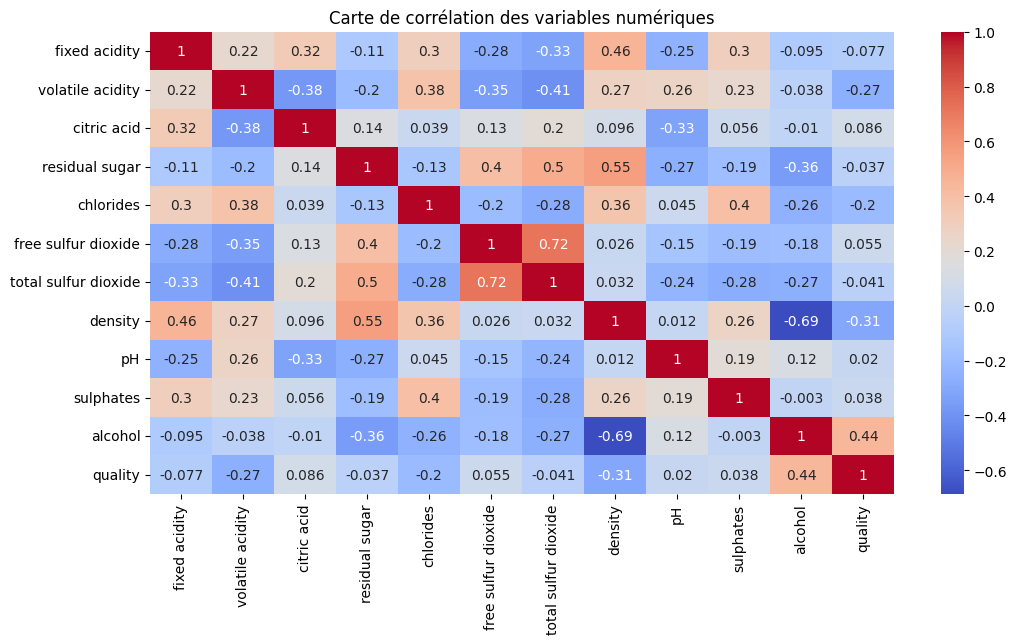

In [32]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.select_dtypes(include=['float64', 'int64']).corr(),
            annot=True, cmap="coolwarm")
plt.title("Carte de corrélation des variables numériques")
plt.show()

### Analyse de la corrélation avec la variable *quality*

L’examen de la matrice de corrélation montre plusieurs relations intéressantes entre les caractéristiques physico-chimiques du vin et la note de qualité attribuée par les experts.

#### 1. Alcohol – corrélation positive modérée (+0.44)
L’alcool est la variable la plus corrélée positivement avec la qualité.
Cela signifie que, en général, **les vins plus alcoolisés tendent à obtenir de meilleures notes**.  
Cela peut s’expliquer par le fait que l’alcool apporte du corps, de la structure et renforce les arômes, caractéristiques souvent associées à des vins mieux perçus.

#### 2. Volatile acidity – corrélation négative notable (–0.27)
L’acidité volatile est négativement corrélée à la qualité.  
Une acidité volatile élevée peut donner un goût ou une odeur désagréable (notes de vinaigre), ce qui **diminue fortement la qualité perçue du vin**.

#### 3. Density – corrélation négative (–0.31)
La densité est également liée négativement à la qualité.  
Les vins de densité plus élevée sont souvent plus sucrés ou moins fermentés, ce qui peut être **moins apprécié dans les vins secs**, majoritaires dans ce dataset.

#### 4. Variables très faiblement corrélées
Les caractéristiques suivantes ont un impact négligeable ou presque nul sur la qualité :

- fixed acidity
- citric acid
- chlorides
- pH
- Residual sugar
- Sulphates
- free sulfur dioxide & total sulfur dioxide

Elles ne montrent aucune tendance forte, positive ou négative.

---

### **Interprétations clés**

- **L’alcool est le facteur principal associé à une meilleure qualité** selon la corrélation.
- **L’acidité volatile et la densité sont les deux facteurs qui diminuent le plus la qualité.**
- La majorité des autres caractéristiques ont un impact faible ou indirect.
- Ces corrélations ne révèlent que des tendances globales : elles ne suffisent pas à prédire la qualité, mais elles aident à comprendre les variables les plus influentes.

Cette analyse sera utile pour la sélection des features et l’interprétation des modèles dans les sections suivantes.

## Remarque importante sur l’interprétation des corrélations

Lors de l’analyse des corrélations, j’ai soulevé un point essentiel : les relations observées (par exemple, l’alcool comme facteur le plus associé à une meilleure qualité ou l’acidité volatile et la densité comme facteurs diminuant la qualité) peuvent varier selon le type de vin.
En effet, les mécanismes chimiques influençant la qualité peuvent différer entre le vin rouge et le vin blanc.

Cependant, dans le cadre de ce projet, l’objectif est de construire un modèle global capable de prédire si un vin est « bon » ou « non » sur l’ensemble du dataset combiné.
Nous conservons donc cette analyse corrélative comme une vue d’ensemble utile, tout en gardant à l’esprit qu’elle ne reflète pas forcément les spécificités propres à chaque type de vin.

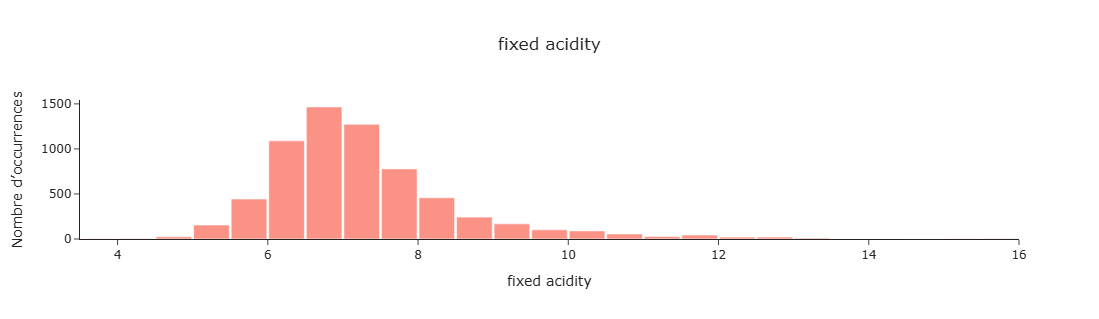

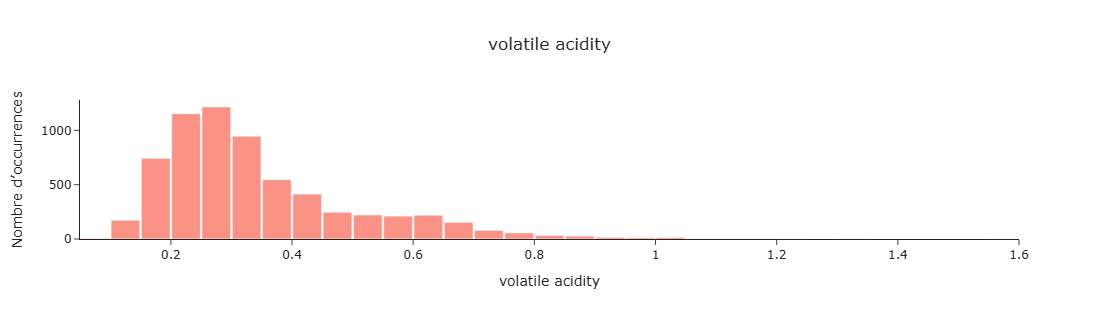

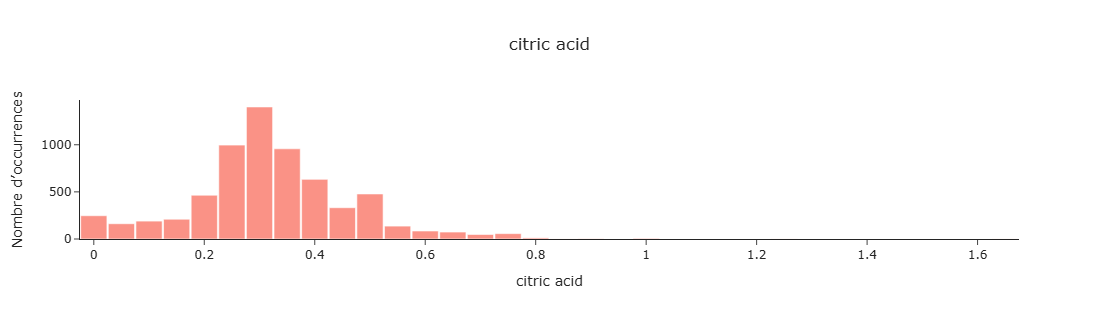

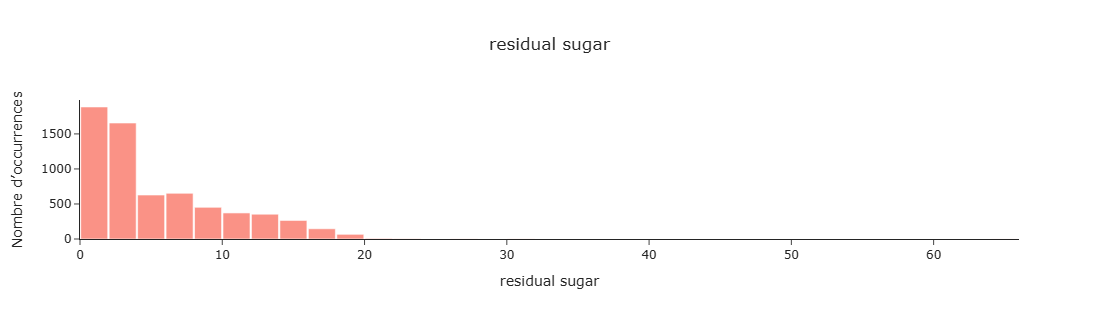

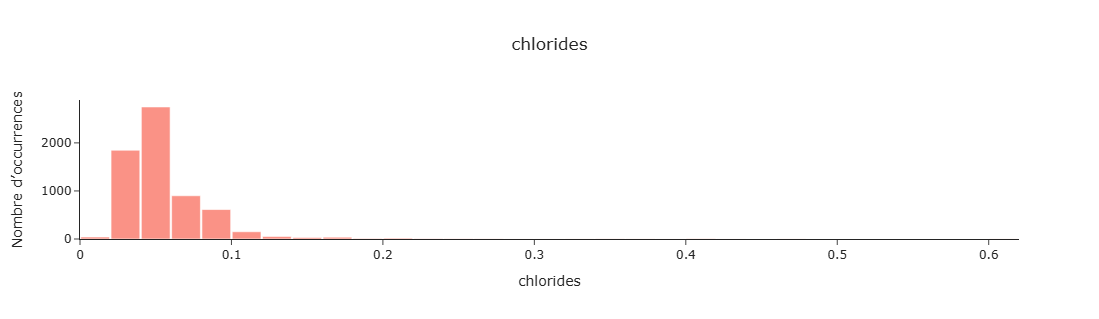

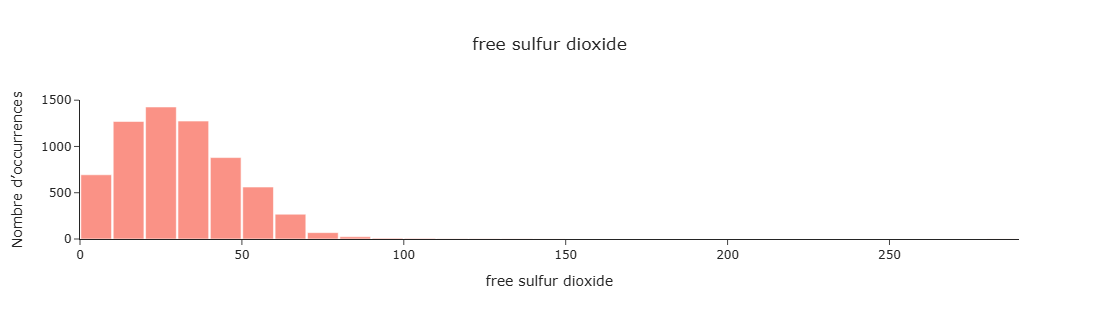

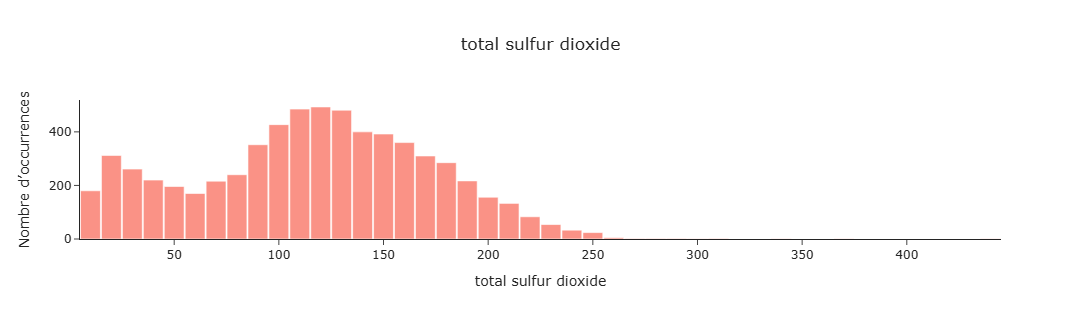

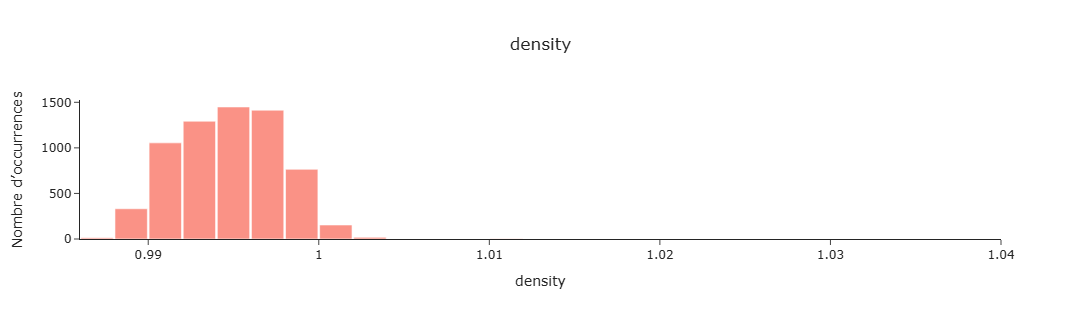

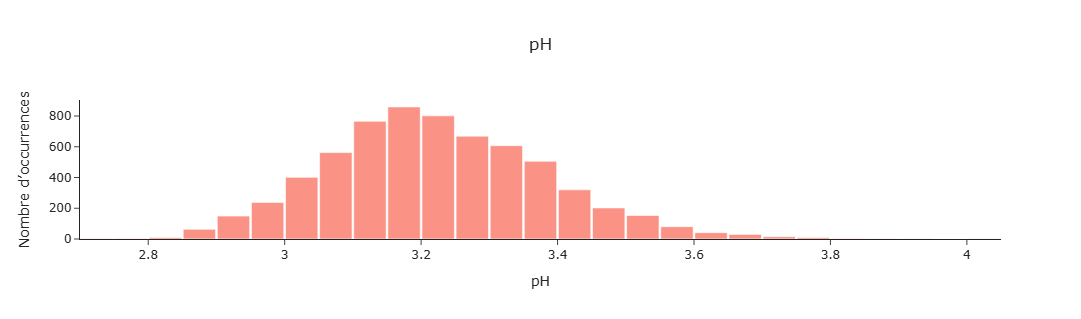

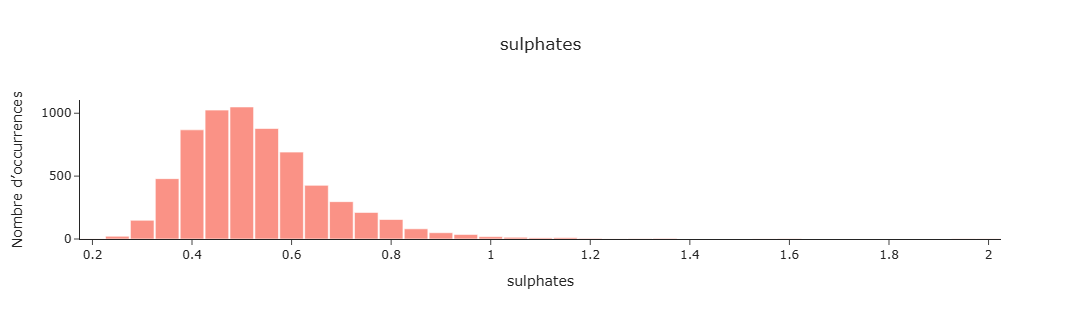

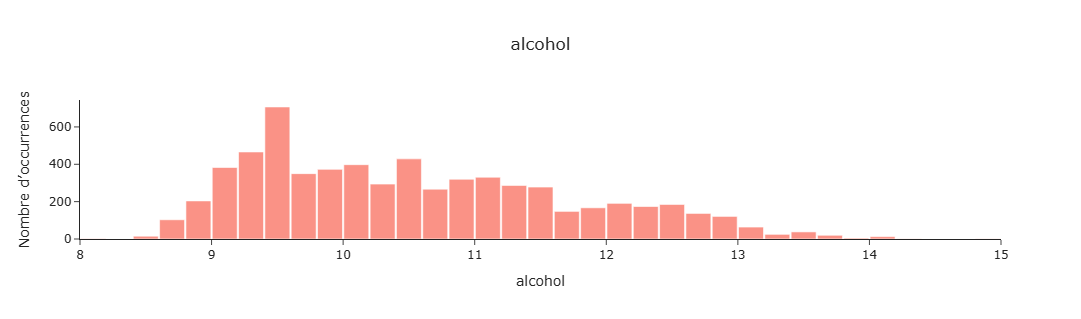

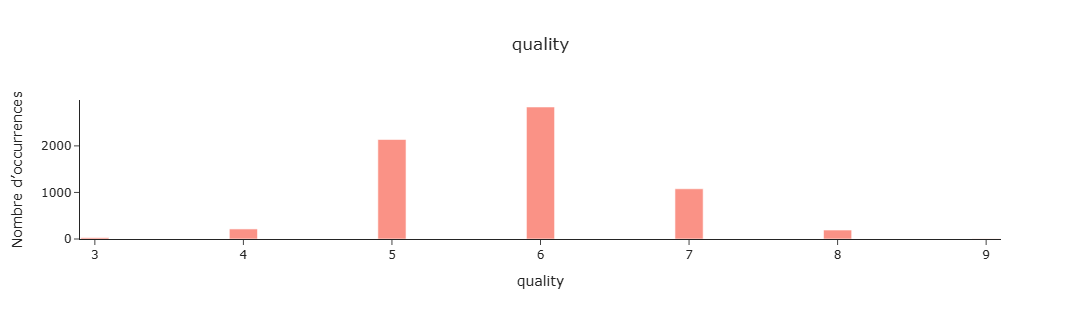

In [36]:
# Colonnes numériques uniquement
num_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    fig = go.Figure()

    fig.add_trace(go.Histogram(
        x=data[col],
        nbinsx=50,
        marker_color='salmon',
        opacity=0.85
    ))

    fig.update_layout(
        title={'text': col, 'x':0.5, 'xanchor':'center'},
        width=1100,
        height=300,
        bargap=0.05,
        xaxis_title=col,
        yaxis_title="Nombre d’occurrences",
        template="simple_white"
    )

    fig.show()

### Observations des distributions

#### 1. Fixed acidity
La distribution de l’acidité fixe est principalement concentrée entre **6 et 8 g/dm³**, ce qui correspond aux valeurs typiques de la majorité des vins. Quelques valeurs plus élevées apparaissent, mais elles restent cohérentes et ne représentent pas d’anomalies.

#### 2. Volatile acidity
Les valeurs se situent majoritairement entre **0.2 et 0.6 g/dm³**, avec une légère asymétrie vers la droite. Une acidité volatile élevée peut altérer l’arôme du vin, ce qui explique son impact négatif sur la qualité mis en évidence dans la matrice de corrélation.

#### 3. Citric acid
La distribution est centrée entre **0.0 et 0.5 g/dm³**, avec un pic autour de 0.25. La présence de valeurs égales à 0 est normale : l’acide citrique peut être très faible ou absent selon le type de vin, comme indiqué dans *winequality.names*.

#### 4. Residual sugar
La majorité des vins ont un sucre résiduel inférieur à **5 g/dm³**, mais la distribution présente une queue à droite en raison de quelques vins plus doux. Cette variabilité est cohérente avec la présence de vins blancs dans le dataset.

#### 5. Alcohol
La distribution est principalement concentrée entre **9 % et 12 %**, avec quelques valeurs légèrement plus élevées.  
L’alcool est la variable la plus corrélée positivement avec la qualité, ce qui signifie que les vins plus alcoolisés tendent généralement à obtenir de meilleures notes.

#### 6. Density
La densité est l’une des variables les plus importantes après l’alcool et l’acidité volatile.  
La distribution est centrée autour de **0.994 – 0.998 g/cm³**, des valeurs typiques pour des vins secs.  
Les densités plus élevées, bien que rares, sont associées à une qualité plus faible (corrélation négative), possiblement en raison d’un sucre résiduel plus important ou d’une fermentation incomplète.

---

### Variables moins impactantes
Les autres variables (chlorides, sulphates, SO₂ libre et total, pH, etc.) présentent des distributions réalistes et ne montrent pas de comportement particulier lié à la qualité visuellement. Leur rôle exact sera clarifié dans les analyses statistiques et les modèles.

---

### Conclusion générale
L’étude des corrélations et des distributions est une étape essentielle avant toute modélisation.
Elle permet de comprendre la structure du dataset et d’anticiper les choix de prétraitement nécessaires.

d'après histogrammes on peux détecter les particularités de chaque variable :

fixed acidity, residual sugar, chlorides, etc. ont des distributions cohérentes et sans anomalies visibles.

volatile acidity est clairement asymétrique, avec une longue queue à droite → cela peut affecter certains modèles sensibles à la distribution comme la régression logistique ou les SVM linéaires.

alcohol présente une distribution plus large et étalée → ce type de variable doit être normalisé pour éviter qu’elle domine les distances dans KNN ou SVM.

density est extrêmement concentrée autour de 0.994–0.998 → cela justifie également une normalisation pour la mettre sur le même ordre de grandeur que les autres variables.

In [45]:
data["quality_binary"] = (data["quality"] >= 7).astype(int)

In [47]:
data["wine_type"] = data["wine type"].map({"red": 0, "white": 1})

## Encodage de la variable qualité et du type de vin
Nous transformons d’abord la variable quality en classe binaire (quality_binary) afin de pouvoir formuler un problème de classification :

**0 → qualité < 7**

**1 → qualité ≥ 7**

Ensuite, la variable wine_type (catégorielle : **red / white**) est encodée en valeurs numériques (**0 / 1**).
Cet encodage est nécessaire car les algorithmes de machine learning ne peuvent traiter que des variables numériques.

In [51]:
data = data.drop(columns=["quality"])

In [56]:
data = data.drop(columns=["wine type"])

Les colonnes "quality et "wine type" ne servent plus donc on les suppriment car on utilise "quality_binary" et "wine_type".

In [58]:
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality_binary  wine_type  
0      9.4               0          0  
1      9.8               0          0  
2      9.8               0          0  
3      9.8               0          0  
4      9.4               0          0

## Détection et suppression des outliers (Local Outlier Factor)
Certaines variables du dataset peuvent contenir des observations extrêmes qui risquent de perturber l’entraînement des modèles (notamment KNN, SVM et la régression linéaire).
Pour détecter ces valeurs aberrantes, nous utilisons Local Outlier Factor (LOF), un algorithme qui identifie les points isolés dans l’espace des caractéristiques.

Le but n’est pas de supprimer beaucoup d'échantillons, mais de retirer les valeurs clairement anormales afin d’obtenir un dataset plus stable avant la standardisation et l’entraînement.

In [62]:
# Séparation X / y
X = data.drop(columns=["quality_binary"]) #toutes les colonnes sauf la cible
y = data["quality_binary"] #la variable cible (quality_binary)

# Modèle LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_flags = lof.fit_predict(X)

# -1 = outlier, 1 = normal
outlier_index = np.where(outlier_flags == -1)[0]

print(f"Nombre d'outliers détectés : {len(outlier_index)}")

# Suppression des outliers
X_clean = X.drop(index=outlier_index)
y_clean = y.drop(index=outlier_index)


Nombre d'outliers détectés : 130


## Standardisation des variables

Après avoir supprimé les outliers, on obtient :

- **X_clean** : toutes les features numériques (fixed acidity, volatile acidity, density, alcohol, etc.)  
- **y_clean** : la cible binaire (*quality_binary*)

De nombreuses variables du dataset (comme *fixed acidity*, *volatile acidity*, *density* ou *alcohol*) n’ont pas la même échelle.

Or, beaucoup de modèles nécessitent une mise à l'échelle, notamment :

- **KNN**
- **SVM**
- **Régression Logistique**

Les modèles basés sur les **arbres de décision** (DecisionTree, RandomForest) ne sont pas sensibles à l’échelle, mais appliquer un scaler ne leur pose aucun problème non plus.

Nous appliquons donc un **StandardScaler**, qui transforme chaque variable pour obtenir :

- une **moyenne = 0**
- un **écart-type = 1**

Cela permet d’entraîner des modèles plus stables et d’éviter qu’une variable avec de grandes valeurs (par exemple *density*) ne domine les autres.
tres.

In [204]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Reconvertir en DataFrame avec les bons noms
X_scaled = pd.DataFrame(X_scaled, columns=X_clean.columns)

X_scaled.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.163316          2.191883    -2.204103       -0.748934   0.571824   
1       0.484364          3.285126    -2.204103       -0.597858   1.199869   
2       0.484364          2.556297    -1.926549       -0.662605   1.028584   
3       3.213269         -0.359015     1.681646       -0.748934   0.543277   
4       0.163316          2.191883    -2.204103       -0.748934   0.571824   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.147828             -1.469112  1.083486  1.807046   0.194372   
1            -0.319097             -0.875556  0.738938 -0.121084   1.004609   
2            -0.911048             -1.109381  0.807848  0.252103   0.802049   
3            -0.792658             -1.001462  1.152395 -0.369875   0.329412   
4            -1.147828             -1.469112  1.083486  1.807046   0.194372   

    alcohol  wine_type  
0 -0.913879  -1.755395  
1 -0.577220  -1.755395  
2 -0.577220  -1.755395  
3 -0.577220  -1.755395  
4 -0.913879  -1.755395

## Séparation du dataset en train et test

Après le nettoyage, la suppression des outliers et la standardisation, nous séparons maintenant les données en deux ensembles :

- **Ensemble d’entraînement (train)** : utilisé pour entraîner les modèles  
- **Ensemble de test** : utilisé uniquement pour évaluer les performances finales

Cette séparation permet de vérifier si les modèles généraliseront bien sur de nouvelles données jamais vues.

Nous utilisons généralement une répartition **80% / 20%**, mais d’autres ratios sont possibles selon la taille du dataset.

Comme notre dataset est déséquilibré (peu de vins de bonne qualité), nous activons
**stratify = y_clean**, ce qui garantit que la proportion des classes est conservée dans train et test.

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_clean,
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)


X_train.shape, X_test.shape

((5093, 12), (1274, 12))

## Équilibrage des classes avec SMOTE

Après la transformation de la variable `quality_binary`, on constate un fort déséquilibre entre les classes :

- **Classe 0 (qualité < 7)** : majoritaire  
- **Classe 1 (qualité ≥ 7)** : minoritaire  

Ce déséquilibre peut nuire aux performances des modèles, car ils ont tendance à favoriser la classe majoritaire.

Pour corriger cela, nous appliquons **SMOTE (Synthetic Minority Oversampling Technique)**, qui génère artificiellement de nouveaux exemples pour la classe minoritaire.  
L’objectif est d’obtenir un dataset équilibré avant l'entraînement des modèles supervisés.

SMOTE est **particulièrement utile** pour les modèles suivants :

- Régression Logistique  
- SVM  
- KNN   

Les arbres (DecisionTree, RandomForest, GradientBoosting) y sont moins sensibles, mais ils bénéficient tout de même d’un dataset équilibré.

Après SMOTE, les deux classes possèdent **le même nombre d'échantillons**, ce qui améliore la stabilité des modèles de classification.

In [208]:
# Initialisation de SMOTE
smote = SMOTE(random_state=42)

# Application de SMOTE sur les données nettoyées et standardisées
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


print("Taille avant SMOTE :", X_train.shape)
print("Taille après SMOTE :", X_train_smote.shape)
print("\nRépartition des classes après SMOTE :")
print(y_train_smote.value_counts())

Taille avant SMOTE : (5093, 12)
Taille après SMOTE : (8170, 12)

Répartition des classes après SMOTE :
quality_binary
0    4085
1    4085
Name: count, dtype: int64


# 2. Modélisation et évaluation

## Justification du choix des modèles

Dans le cadre de cette étude, l’objectif est de prédire si un vin est de bonne qualité (**quality ≥ 7**) à partir de mesures physico-chimiques **continues**.  
Le dataset présente :

- des relations **majoritairement non linéaires** (corrélations faibles à modérées),  
- des distributions **hétérogènes** (variables asymétriques, densité très concentrée, alcohol très étalé),
- un **déséquilibre de classes**, corrigé partiellement avec SMOTE,  
- des variables **normalisées** grâce au *StandardScaler*.

Afin de couvrir différents comportements de modèles et d’observer leur réaction au déséquilibre puis à SMOTE, nous retenons les modèles suivants :

---

### Régression Logistique
- Modèle **linéaire**, simple à interpréter.  
- Sert de **baseline** pour vérifier si les relations linéaires suffisent.  
- Très adaptée à des données **normalisées**, ce qui est notre cas.  
- Permet d’évaluer si la qualité peut être séparée proprement par un **hyperplan linéaire**.

---

### k-Nearest Neighbors (k-NN)
- Modèle **non paramétrique**, très sensible à l’échelle des variables → d’où l’importance du *scaling*.  
- Utile pour observer si les classes se regroupent **localement** dans l’espace des features.  
- Très sensible au **déséquilibre des classes**, ce qui rend la comparaison avant/après SMOTE très pertinente.

---

### Arbre de Décision
- Modèle **non linéaire**, capable de capturer des interactions complexes entre variables.  
- Ne nécessite pas de normalisation (mais fonctionne aussi sur données scalées).  
- Permet de visualiser explicitement les **règles de décision** utilisées pour prédire la qualité du vin.  
- Peu sensible à l’échelle des variables, mais **sensible au déséquilibre de classes** → comparaison utile avec SMOTE.

---

### Naive Bayes
- Modéle probabiliste repose sur l’hypothèse d’indépendance conditionnelle entre les variables.
  Même si cette hypothèse est simplificatrice, il fonctionne bien sur des données continues standardisées.
  Il sert également de point de comparaison théorique pour les autres modèles.  
- Modèle très **rapide**, idéal pour une baseline probabiliste.  
- Fonctionne bien même avec des **distributions différentes** entre variables, ce qui correspond à notre dataset.

---

### Support Vector Machine (SVM)
- Modèle puissant pour séparer des données **non linéaires**, surtout avec un kernel RBF.  
- Requiert une **normalisation stricte**, que nous avons appliquée.  
- Adapté à des frontières de décision **complexes**, ce qui est cohérent avec nos distributions et corrélations.  
- Sensible au déséquilibre des classes → analyse très informative avant/après SMOTE.

---

## Conclusion : Pourquoi ces modèles pour *ce* dataset ?

Les modèles sélectionnés couvrent un spectre large :

- **Linéaires** → Régression Logistique  
- **Basés sur la distance** → k-NN  
- **Arbres non linéaires** → DecisionTree  
- **Probabilistes** → Naive Bayes  
- **Modèles à marge maximale** → SVM  

Ce choix permet :

- d’évaluer si les relations du dataset sont **linéaires ou non**,  
- de comparer les performances sur un dataset **déséquilibré vs équilibré (SMOTE)**,  
- de tester quels modèles sont les plus adaptés à des **mesures physico-chimiques continues**,  
- d’obtenir une vision complète de la difficulté du problème de classification.




===== Modèle : Régression Logistique =====
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1022
           1       0.60      0.25      0.36       252

    accuracy                           0.82      1274
   macro avg       0.72      0.61      0.63      1274
weighted avg       0.79      0.82      0.79      1274



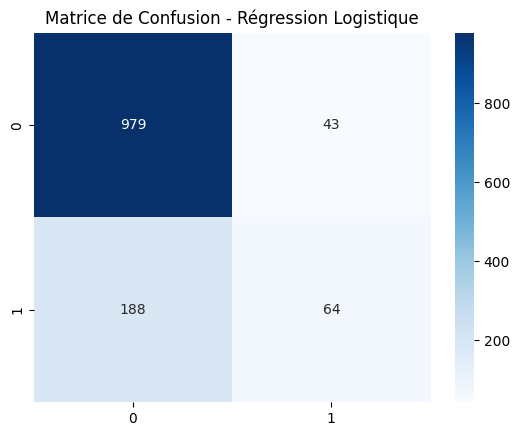


===== Modèle : k-NN =====
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1022
           1       0.61      0.56      0.58       252

    accuracy                           0.84      1274
   macro avg       0.75      0.73      0.74      1274
weighted avg       0.84      0.84      0.84      1274



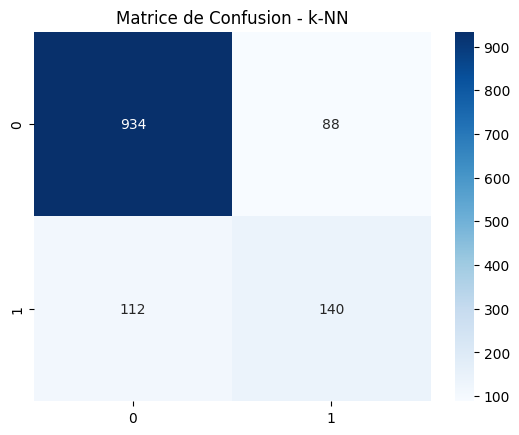


===== Modèle : Arbre de Décision =====
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1022
           1       0.58      0.65      0.61       252

    accuracy                           0.84      1274
   macro avg       0.75      0.77      0.76      1274
weighted avg       0.85      0.84      0.84      1274



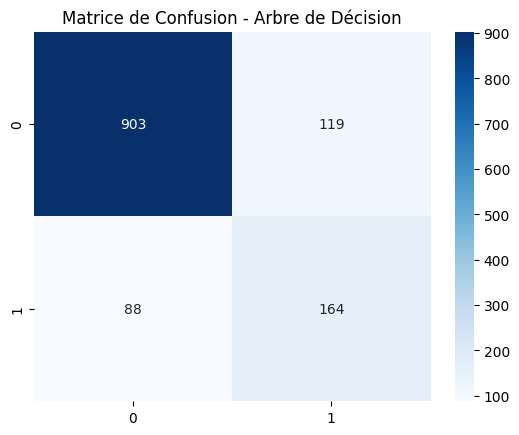


===== Modèle : Naive Bayes =====
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1022
           1       0.38      0.69      0.49       252

    accuracy                           0.71      1274
   macro avg       0.64      0.70      0.64      1274
weighted avg       0.80      0.71      0.74      1274



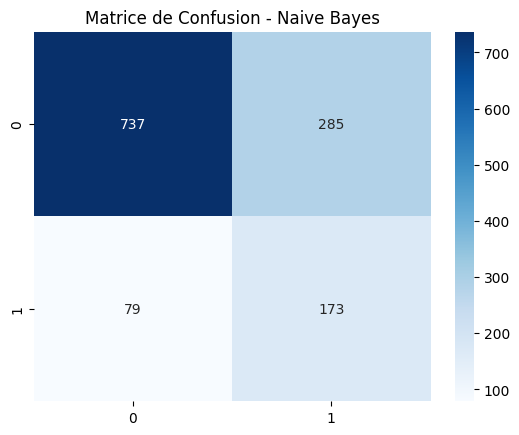


===== Modèle : SVM =====
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1022
           1       0.65      0.29      0.40       252

    accuracy                           0.83      1274
   macro avg       0.75      0.63      0.65      1274
weighted avg       0.81      0.83      0.80      1274



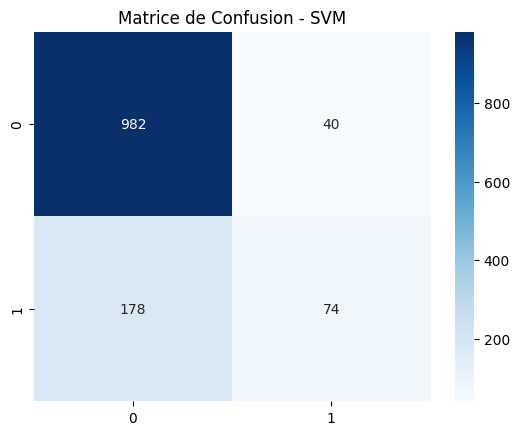

Modèle  Accuracy  Precision    Recall  F1-score
0  Régression Logistique  0.818681   0.598131  0.253968  0.356546
1                   k-NN  0.843014   0.614035  0.555556  0.583333
2      Arbre de Décision  0.837520   0.579505  0.650794  0.613084
3            Naive Bayes  0.714286   0.377729  0.686508  0.487324
4                    SVM  0.828885   0.649123  0.293651  0.404372

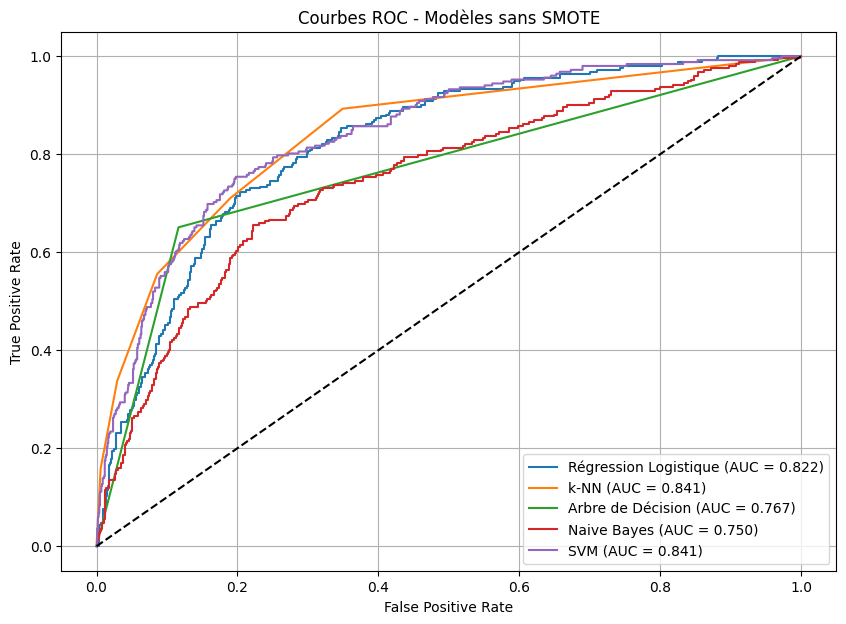

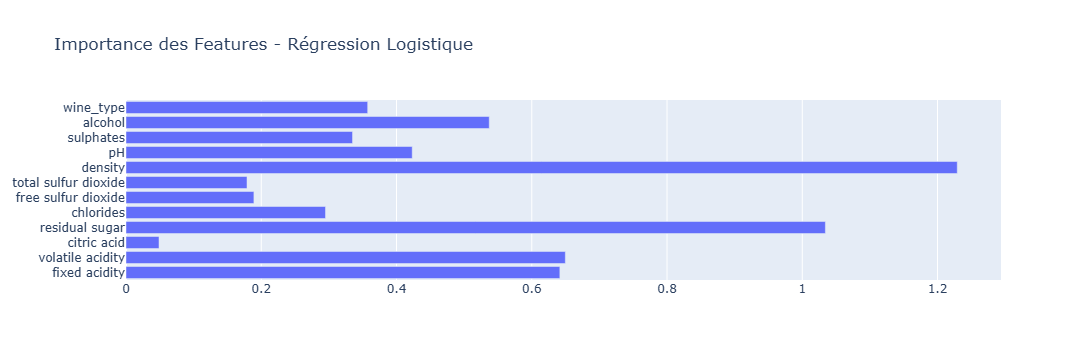

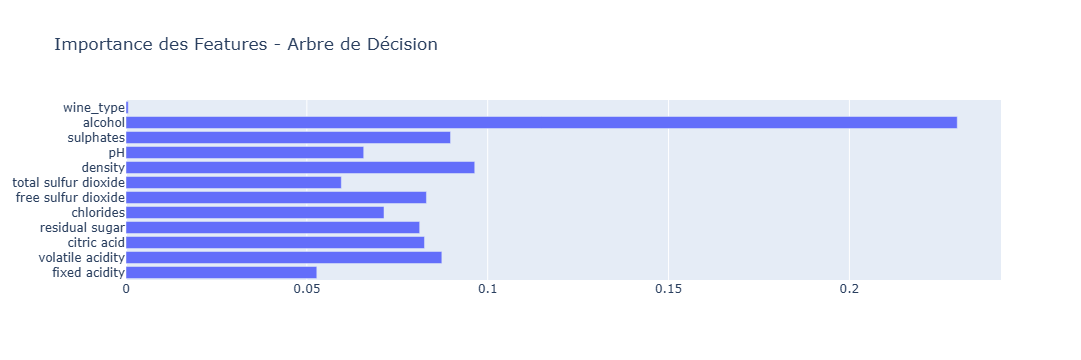

In [210]:
# --------------------------------------------------------
# 1. Création d'un dictionnaire de modèles
# --------------------------------------------------------

models = {
    "Régression Logistique": (LogisticRegression(max_iter=500), X_train, X_test),
    "k-NN": (KNeighborsClassifier(n_neighbors=5), X_train, X_test),
    "Arbre de Décision": (DecisionTreeClassifier(random_state=42), X_train, X_test),
    "Naive Bayes": (GaussianNB(), X_train, X_test),
    "SVM": (SVC(kernel="rbf", probability=True), X_train, X_test)
}
results = []        # pour stocker les scores
roc_curves = {}     # pour tracer les ROC plus tard

# --------------------------------------------------------
# 2. Entraînement + prédictions + métriques
# --------------------------------------------------------

for name, (model, Xtr, Xte) in models.items():
    print(f"\n===== Modèle : {name} =====")
    
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:,1] if hasattr(model,"predict_proba") else None


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de Confusion - {name}")
    plt.show()

    # ROC–AUC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        roc_curves[name] = (fpr, tpr, roc_auc)


# --------------------------------------------------------
# 3. Tableau résumé des performances
# --------------------------------------------------------

import pandas as pd

df_results = pd.DataFrame(results, columns=["Modèle", "Accuracy", "Precision", "Recall", "F1-score"])
display(df_results)


# --------------------------------------------------------
# 4. Tracé des courbes ROC
# --------------------------------------------------------

plt.figure(figsize=(10, 7))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC - Modèles sans SMOTE")
plt.legend()
plt.grid()
plt.show()


# --------------------------------------------------------
# 5. Importance des Features (Logistic Regression + Decision Tree)
# --------------------------------------------------------

# Liste des noms des colonnes
feature_names = X_clean.columns


# ===== Logistic Regression =====
log_reg_model = models["Régression Logistique"][0]   # EXTRACTION DU MODELE
coeffs = log_reg_model.coef_[0]                      # coefficients du modèle

fig = go.Figure(go.Bar(
    x=np.abs(coeffs),
    y=feature_names,
    orientation='h'
))
fig.update_layout(title="Importance des Features - Régression Logistique")
fig.show()


# ===== Decision Tree =====
tree_model = models["Arbre de Décision"][0]          # EXTRACTION DU MODELE
importances = tree_model.feature_importances_

fig = go.Figure(go.Bar(
    x=importances,
    y=feature_names,
    orientation='h'
))
fig.update_layout(title="Importance des Features - Arbre de Décision")
fig.show()

## Synthèse des résultats — Modèles sans SMOTE
###  **1. Résultats globaux des modèles**

Les performances montrent que :

- Les modèles **prédissent très bien la classe majoritaire (0 : vin “normal”)**, avec des recalls souvent > 0.90.
- En revanche, la **classe minoritaire (1 : vin de bonne qualité)** est nettement moins bien prédite par tous les modèles.
  
Les scores F1 de la classe 1 sont faibles, ce qui confirme que le **déséquilibre du dataset pénalise fortement la détection des bons vi

### **2. Comparaison des modèles**

#### Régression Logistique
- **Accuracy** : 0.82

- **F1-score (classe 1)** : 0.36

- **AUC** : 0.822

- Très bonne détection de la classe négative (qualité < 7), mais beaucoup de faux négatifs.

- Sensible au déséquilibre : difficulté à capturer la classe rare.

#### k-NN (k = 5)
- **Accuracy** : 0.84 

- **F1-score (classe 1)** : 0.58

- **AUC** : 0.841

- Montre une meilleure capacité que la régression logistique pour détecter les vins de bonne qualité.

- Bénéficie fortement de la standardisation appliquée en prétraitement.

#### Arbre de Décision
- **Accuracy** : 0.84

- **F1-score (classe 1)** : 0.61

- **AUC** : 0.767

- Capte mieux les relations non linéaires.

- Arrive à récupérer davantage de vrais positifs que la régression logistique, au prix de quelques faux positifs supplémentaires.

#### Naive Bayes
- **Accuracy** : 0.71

- **F1-score (classe 1)** : 0.49

- **AUC** : 0.750

- Modèle moins performant sur ce dataset.

- Hypothèse d’indépendance trop forte, ce qui ne correspond pas aux relations entre variables du vin.

#### SVM
- **Accuracy** : 0.83

- **F1-score (classe 1)** : 0.40

- **AUC** : 0.841 (excellent score ROC)

- Très bon classement global mais rappel faible sur la classe positive.

- Montre son efficacité sur la séparation de classes, mais n'arrive pas à compenser le déséquilibre.

## **3. Importance des Features**
## Régression Logistique

Les coefficients montrent que :

- **density**, **alcohol**, **volatile acidity**, **residual sugar** sont les variables les plus influentes.

- Le type de vin **(wine_type)** joue également un rôle notable.

## Arbre de Décision

Les features dominantes sont :

- **alcohol**, **density**, **sulphates**, **volatile acidity**, citric acid
Ces résultats confirment l’analyse de corrélation effectuée en prétraitement.

### **3. Bilan général sans SMOTE**

- Les modèles détectent très bien la classe majoritaire, mais ont du mal à identifier les vins de bonne qualité.

- Le déséquilibre des classes entraîne une chute du recall et du F1-score pour la classe positive.

- Les modèles non linéaires (k-NN, Arbre) s'en sortent mieux que les modèles linéaires.

- La régression logistique et SVM ont de bonnes AUC mais peinent sur la classe 1.

En résumé :
- Le problème principal n’est pas la complexité du modèle, mais le déséquilibre des classes.

### **Étape suivante : modèles avec SMOTE**

Dans la prochaine section, nous allons reproduire exactement la même évaluation, mais cette fois sur des données rééquilibrées avec SMOTE.


- vérifier si le rappel et le F1-score de la classe positive s’améliorent,

- comparer l’impact de SMOTE sur les différents modèles,

- observer si certains algorithmes (ex. k-NN, SVM) bénéficient significativement de l'oversampling.

Nous allons maintenant voir si SMOTE permet d’obtenir de meilleures performances sur la prédiction des vins de haute qualité.ns**.


===== Modèle (SMOTE) : Régression Logistique =====
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1022
           1       0.40      0.78      0.53       252

    accuracy                           0.72      1274
   macro avg       0.66      0.74      0.67      1274
weighted avg       0.82      0.72      0.75      1274



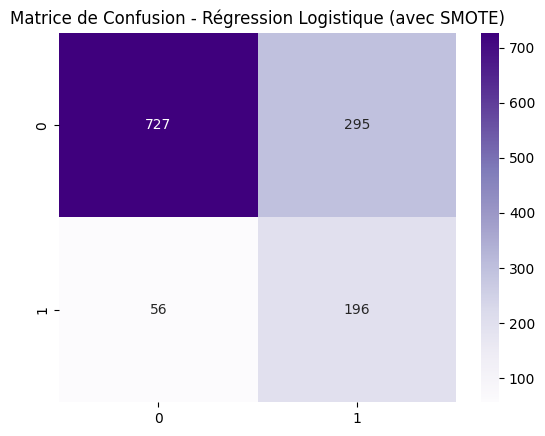


===== Modèle (SMOTE) : k-NN =====
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1022
           1       0.46      0.79      0.58       252

    accuracy                           0.77      1274
   macro avg       0.70      0.78      0.71      1274
weighted avg       0.84      0.77      0.79      1274



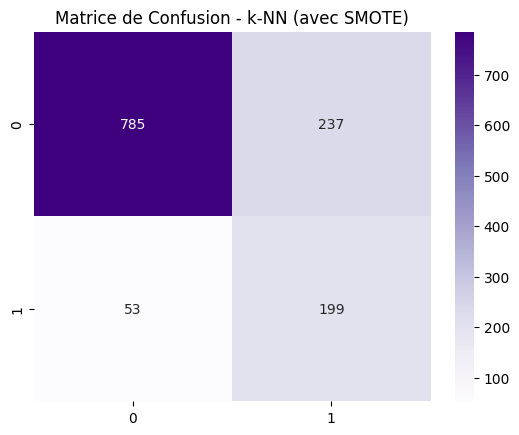


===== Modèle (SMOTE) : Arbre de Décision =====
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1022
           1       0.55      0.70      0.62       252

    accuracy                           0.83      1274
   macro avg       0.74      0.78      0.75      1274
weighted avg       0.85      0.83      0.83      1274



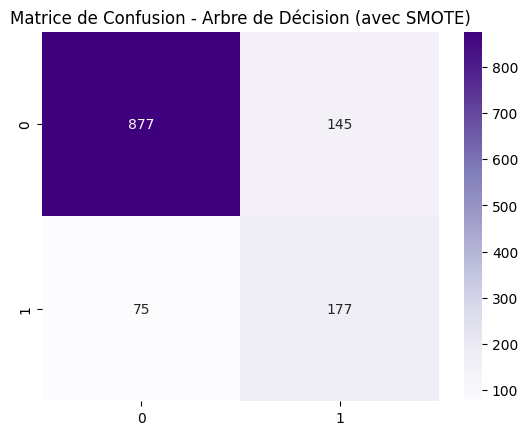


===== Modèle (SMOTE) : Naive Bayes =====
              precision    recall  f1-score   support

           0       0.92      0.56      0.69      1022
           1       0.31      0.79      0.44       252

    accuracy                           0.61      1274
   macro avg       0.61      0.68      0.57      1274
weighted avg       0.80      0.61      0.64      1274



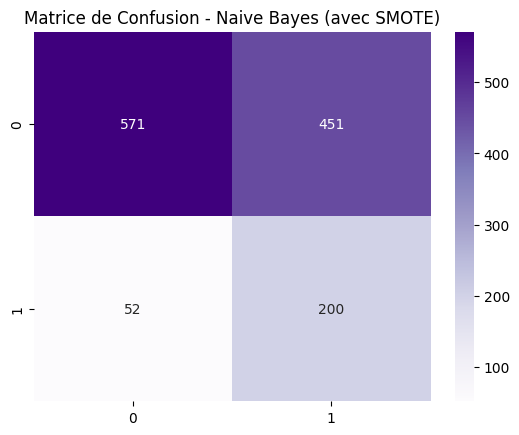


===== Modèle (SMOTE) : SVM =====
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1022
           1       0.43      0.81      0.56       252

    accuracy                           0.75      1274
   macro avg       0.69      0.77      0.69      1274
weighted avg       0.84      0.75      0.77      1274



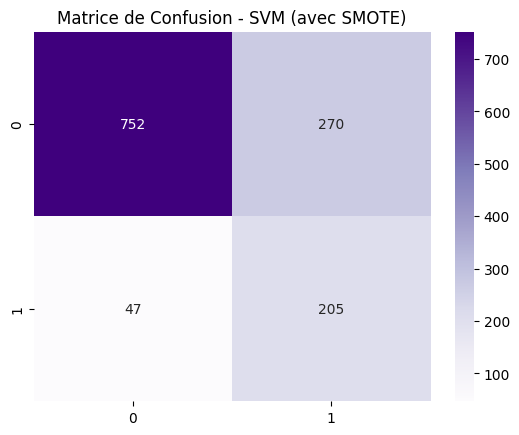

Modèle  Accuracy  Precision    Recall  F1-score
0  Régression Logistique  0.724490   0.399185  0.777778  0.527591
1                   k-NN  0.772370   0.456422  0.789683  0.578488
2      Arbre de Décision  0.827316   0.549689  0.702381  0.616725
3            Naive Bayes  0.605181   0.307220  0.793651  0.442968
4                    SVM  0.751177   0.431579  0.813492  0.563961

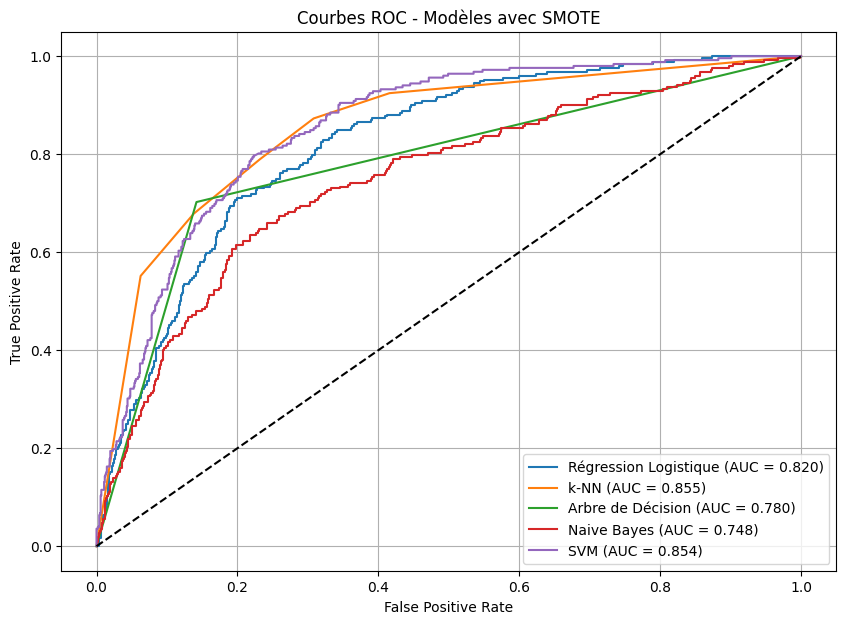

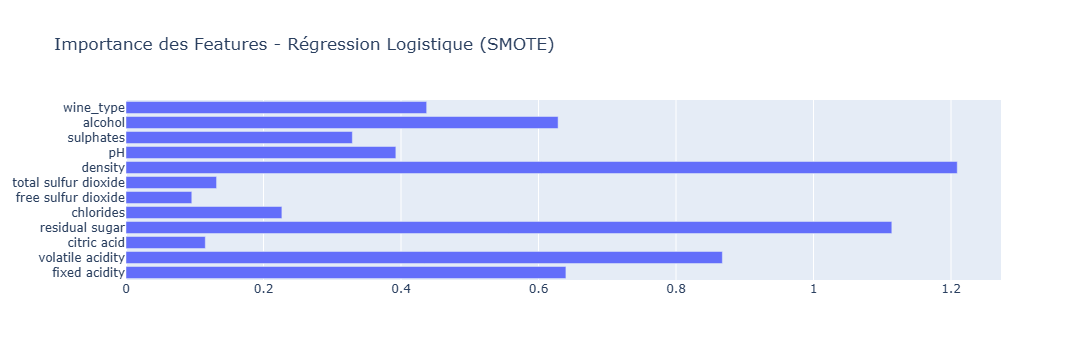

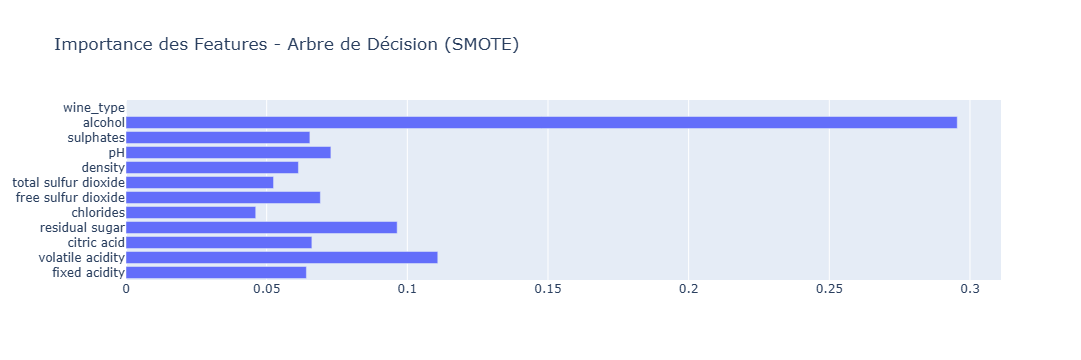

In [212]:
# =======================================================
#     ÉVALUATION DES MODÈLES — VERSION AVEC SMOTE
# =======================================================

# --------------------------------------------------------
# 1. Création d'un dictionnaire de modèles
# --------------------------------------------------------

models_smote = {
    "Régression Logistique": LogisticRegression(max_iter=500),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Arbre de Décision": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel="rbf", probability=True)
}

results_smote = []       # stocker les scores
roc_curves_smote = {}    # pour les courbes ROC


# --------------------------------------------------------
# 2. Entraînement + prédictions + métriques
# --------------------------------------------------------

for name, model in models_smote.items():
    print(f"\n===== Modèle (SMOTE) : {name} =====")
    
    # entraînement sur SMOTE
    model.fit(X_train_smote, y_train_smote)

    # prédictions sur le test set NORMAL (important !)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # métriques
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results_smote.append([name, acc, prec, rec, f1])

    print(classification_report(y_test, y_pred))

    # matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
    plt.title(f"Matrice de Confusion - {name} (avec SMOTE)")
    plt.show()

    # ROC–AUC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        roc_curves_smote[name] = (fpr, tpr, roc_auc)



# --------------------------------------------------------
# 3. Tableau résumé des performances
# --------------------------------------------------------

df_results_smote = pd.DataFrame(results_smote, 
                    columns=["Modèle", "Accuracy", "Precision", "Recall", "F1-score"])
display(df_results_smote)



# --------------------------------------------------------
# 4. Tracé des courbes ROC (version SMOTE)
# --------------------------------------------------------

plt.figure(figsize=(10, 7))
for name, (fpr, tpr, roc_auc) in roc_curves_smote.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC - Modèles avec SMOTE")
plt.legend()
plt.grid()
plt.show()



# --------------------------------------------------------
# 5. Importance des Features (Logistic Regression + Decision Tree)
# --------------------------------------------------------

# Logistic Regression
log_reg_smote = models_smote["Régression Logistique"]
coeffs = log_reg_smote.coef_[0]

fig = go.Figure(go.Bar(
    x=np.abs(coeffs),
    y=X_train.columns,
    orientation='h'
))
fig.update_layout(title="Importance des Features - Régression Logistique (SMOTE)")
fig.show()


# Decision Tree
tree_smote = models_smote["Arbre de Décision"]

fig = go.Figure(go.Bar(
    x=tree_smote.feature_importances_,
    y=X_train.columns,
    orientation='h'
))
fig.update_layout(title="Importance des Features - Arbre de Décision (SMOTE)")
fig.show()

In [180]:
# ==========================================================
#        OPTIMISATION DES HYPERPARAMÈTRES (GRID & RANDOM)
# ==========================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import randint, uniform
import pandas as pd

from sklearn.model_selection import GridSearchCV

# ==========================================================
# 1️⃣ GRID SEARCH — k-NN
# ==========================================================

param_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_knn,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_knn.fit(X_train_scaled, y_train)

print("Best params KNN :", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_
# ==========================================================
# 2️⃣ GRID SEARCH — SVM
# ==========================================================

param_svm = {
    "C": [0.1, 1, 10, 50],
    "gamma": ["scale", "auto", 0.01, 0.001],
    "kernel": ["rbf", "poly"]
}

grid_svm = GridSearchCV(
    SVC(probability=True),
    param_svm,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_svm.fit(X_train_scaled, y_train)

print("Best params SVM :", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_



param_tree = {
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "criterion": ["gini", "entropy"]
}

rand_tree = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_tree,
    n_iter=20,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

rand_tree.fit(X_train_raw, y_train)

print("Best params Decision Tree :", rand_tree.best_params_)
best_tree = rand_tree.best_estimator_



param_log = {
    "C": uniform(0.01, 10),
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

rand_log = RandomizedSearchCV(
    LogisticRegression(max_iter=1000),
    param_log,
    n_iter=20,
    cv=5,
    scoring="f1",
    random_state=42,
    n_jobs=-1
)

rand_log.fit(X_train_scaled, y_train)

print("Best params Logistic Regression :", rand_log.best_params_)
best_log = rand_log.best_estimator_


Best params KNN : {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best params SVM : {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Best params Decision Tree : {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best params Logistic Regression : {'C': 3.7554011884736247, 'penalty': 'l2', 'solver': 'lbfgs'}



===== Régression Logistique (OPT) =====
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1022
           1       0.60      0.25      0.36       252

    accuracy                           0.82      1274
   macro avg       0.72      0.61      0.63      1274
weighted avg       0.79      0.82      0.79      1274



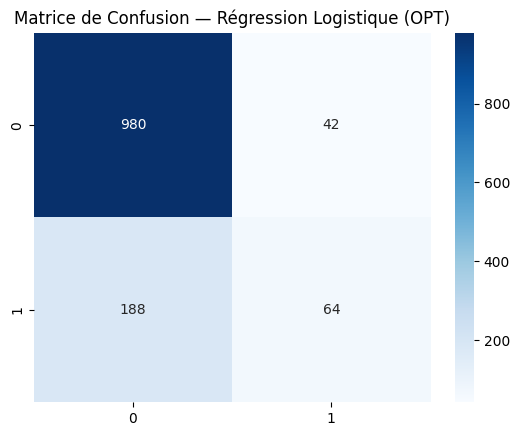


===== k-NN (OPT) =====
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1022
           1       0.68      0.61      0.65       252

    accuracy                           0.87      1274
   macro avg       0.80      0.77      0.78      1274
weighted avg       0.86      0.87      0.86      1274



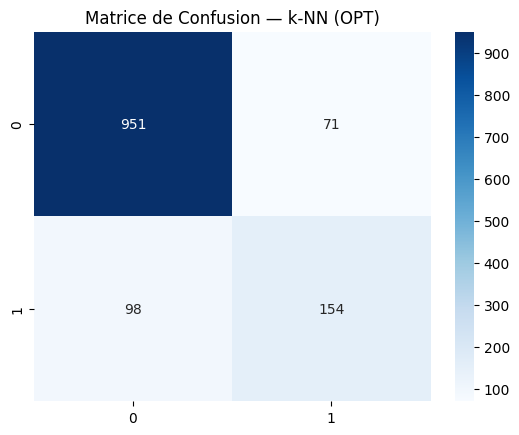


===== Arbre de Décision (OPT) =====
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1022
           1       0.58      0.60      0.59       252

    accuracy                           0.84      1274
   macro avg       0.74      0.75      0.74      1274
weighted avg       0.84      0.84      0.84      1274



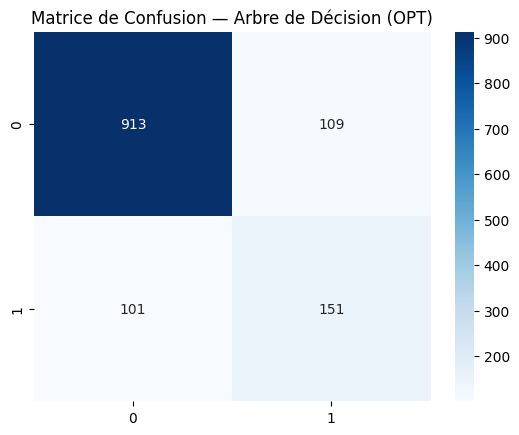


===== Naive Bayes =====
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1022
           1       0.38      0.69      0.49       252

    accuracy                           0.71      1274
   macro avg       0.64      0.70      0.64      1274
weighted avg       0.80      0.71      0.74      1274



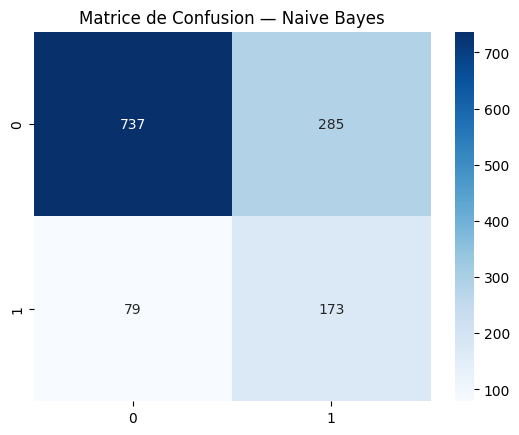


===== SVM (OPT) =====
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1022
           1       0.62      0.48      0.54       252

    accuracy                           0.84      1274
   macro avg       0.75      0.70      0.72      1274
weighted avg       0.83      0.84      0.83      1274



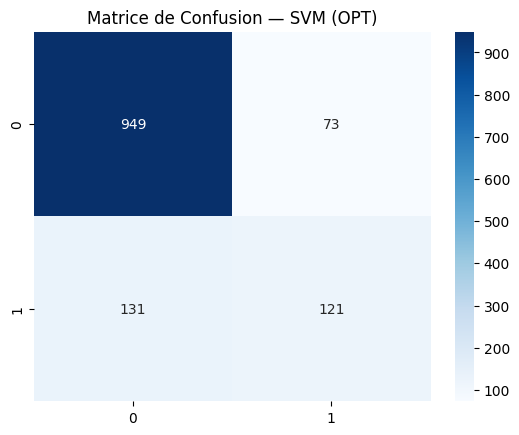

Modèle  Accuracy  Precision    Recall  F1-score
0  Régression Logistique (OPT)  0.819466   0.603774  0.253968  0.357542
1                   k-NN (OPT)  0.867347   0.684444  0.611111  0.645702
2      Arbre de Décision (OPT)  0.835165   0.580769  0.599206  0.589844
3                  Naive Bayes  0.714286   0.377729  0.686508  0.487324
4                    SVM (OPT)  0.839874   0.623711  0.480159  0.542601

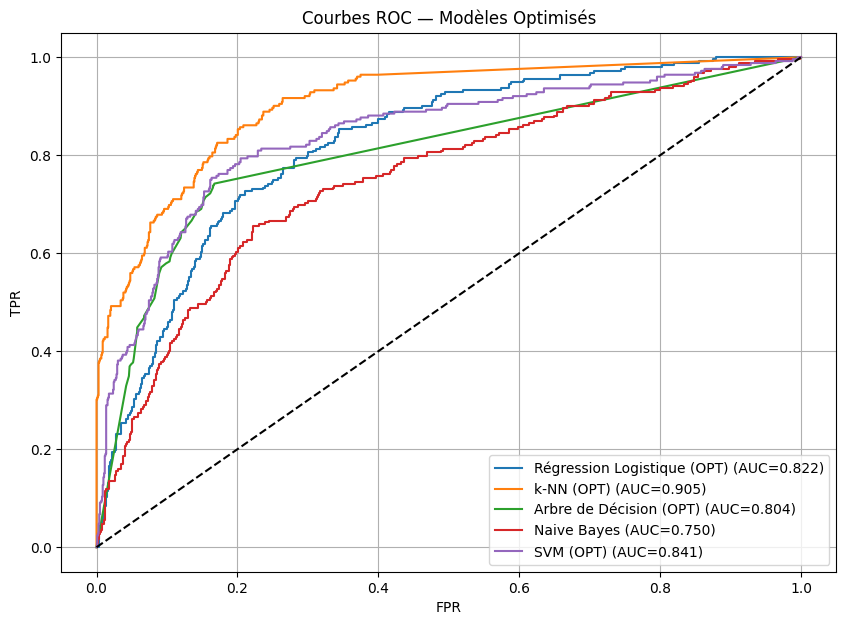

In [214]:
models_opt = {
    "Régression Logistique (OPT)": (best_log, X_train, X_test),
    "k-NN (OPT)": (best_knn, X_train, X_test),
    "Arbre de Décision (OPT)": (best_tree, X_train, X_test),
    "Naive Bayes": (GaussianNB(), X_train, X_test),
    "SVM (OPT)": (best_svm, X_train, X_test)
}
results_opt = []
roc_curves_opt = {}

for name, (model, Xtr, Xte) in models_opt.items():

    print(f"\n===== {name} =====")
    
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results_opt.append([name, acc, prec, rec, f1])

    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Matrice de Confusion — {name}")
    plt.show()

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        roc_curves_opt[name] = (fpr, tpr, roc_auc)

df_opt = pd.DataFrame(results_opt, columns=["Modèle", "Accuracy", "Precision", "Recall", "F1-score"])
display(df_opt)

plt.figure(figsize=(10, 7))

for name, (fpr, tpr, roc_auc) in roc_curves_opt.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Courbes ROC — Modèles Optimisés")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()